In [8]:
import numpy as np
import pandas as pd
import re

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [15]:
data = pd.read_csv("emotion-dataset.csv")

In [18]:
data.head(5)

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [19]:
col_list = ['text', 'sentiment']

In [20]:
data = data[col_list]

In [21]:
data.head(5)

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [28]:
data = data[data.sentiment!= "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [29]:
data.head(4)

,text,sentiment
1,rt scottwalker didnt catch the full gopdebate ...,Positive
3,rt robgeorge that carly fiorina is trending h...,Positive
4,rt danscavino gopdebate w realdonaldtrump deli...,Positive
5,rt gregabbott_tx tedcruz on my first day i wil...,Positive


In [30]:
for idx, row in data.iterrows():
    row[0] = row[0].replace('rt', '')

In [31]:
data.head(4)

,text,sentiment
1,scottwalker didnt catch the full gopdebate la...,Positive
3,robgeorge that carly fiorina is trending hou...,Positive
4,danscavino gopdebate w realdonaldtrump delive...,Positive
5,gregabbott_tx tedcruz on my first day i will ...,Positive


In [38]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split= ' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
X[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         359,  120,    1,  692,    2,   39,   58,  234,   37,  207,    6,
         172, 1745,   12, 1308, 1394,  733],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          16,  281,  249,    5,  809,  102,  170,   26,  134,    6,    1,
         171,   12,    2,  231,  713,   17]], dtype=int32)

In [39]:
embed_dim = 128
lstm_out = 196

In [45]:
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
Y = pd.get_dummies(data['sentiment']).values

In [48]:
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.4, random_state=42)

In [127]:
graph = model.fit(X_train, Y_train, epochs=15, batch_size = 256, verbose=1)

Epoch 1/15
34/34 [==============================] - 8s 197ms/step - loss: 0.0644 - accuracy: 0.9725
Epoch 2/15
34/34 [==============================] - 7s 191ms/step - loss: 0.0535 - accuracy: 0.9760
Epoch 3/15
34/34 [==============================] - 6s 185ms/step - loss: 0.0493 - accuracy: 0.9786
Epoch 4/15
34/34 [==============================] - 7s 195ms/step - loss: 0.0510 - accuracy: 0.9769
Epoch 5/15
34/34 [==============================] - 6s 190ms/step - loss: 0.0508 - accuracy: 0.9773
Epoch 6/15
34/34 [==============================] - 7s 199ms/step - loss: 0.0500 - accuracy: 0.9774
Epoch 7/15
34/34 [==============================] - 6s 186ms/step - loss: 0.0487 - accuracy: 0.9796
Epoch 8/15
34/34 [==============================] - 6s 180ms/step - loss: 0.0510 - accuracy: 0.9783
Epoch 9/15
34/34 [==============================] - 6s 186ms/step - loss: 0.0523 - accuracy: 0.9776
Epoch 10/15
34/34 [==============================] - 6s 185ms/step - loss: 0.0501 - accuracy: 0.9794

In [53]:
Y_pred = model.predict_classes(X_test,batch_size = 256)


In [59]:
data_test = pd.DataFrame({
    'salt': Y_test.tolist(),
    'pred': Y_pred
})

data_test['salt'] = data_test['salt'].apply(lambda x: np.argmax(x))

In [60]:
data_test

,salt,pred
0,1,1
1,1,1
2,0,1
3,0,1
4,1,1
...,...,...
4287,0,1
4288,0,1
4289,0,1
4290,1,1


In [62]:
data_positive = data[data['sentiment'] == 'Positive']
data_negative = data[data['sentiment'] == 'Negative']

In [63]:
data_negative

,text,sentiment
6,warriorwoman91 i liked her and was happy when...,Negative
8,deer in the headlights lizzwinstead ben carso...,Negative
9,nancyosborne180 last nights debate proved it ...,Negative
10,jgreendc realdonaldtrump in all fairness billc...,Negative
12,me reading my familys comments about how great...,Negative
...,...,...
13863,so trans soldiers can die for you huckabee but...,Negative
13864,rwsurfergirl is it just me or does anyone els...,Negative
13865,rwsurfergirl fox is cherry picking the candid...,Negative
13866,cappy_yarbrough love to see men who will neve...,Negative


In [64]:
data_positive

,text,sentiment
1,scottwalker didnt catch the full gopdebate la...,Positive
3,robgeorge that carly fiorina is trending hou...,Positive
4,danscavino gopdebate w realdonaldtrump delive...,Positive
5,gregabbott_tx tedcruz on my first day i will ...,Positive
11,waynedupreeshow just woke up to tweet this ou...,Positive
...,...,...
13859,best line of gopdebate was immigration without...,Positive
13862,rwsurfergirl trump has got it right nobody wo...,Positive
13867,georgehenryw who thought huckabee exceeded th...,Positive
13868,lrihendry tedcruz as president i will always ...,Positive


In [65]:
bias = data_positive.shape[0] / data_negative.shape[0]

In [66]:
bias

0.26327563876133286

In [67]:
train = pd.concat([data_negative.sample(frac=0.8, random_state=200),
                  data_positive.sample(frac=0.8, random_state=200)])

test = pd.concat([data_negative.drop(data_negative.sample(frac=0.8, random_state=200).index),
                 data_positive.drop(data_positive.sample(frac=0.8, random_state=200).index)])

In [68]:
train = shuffle(train)
test = shuffle(test)

In [79]:
train.sentiment

11889    Negative
5270     Negative
5108     Negative
4508     Negative
7747     Negative
           ...   
10704    Positive
11920    Negative
13484    Negative
10601    Negative
2629     Positive
Name: sentiment, Length: 8583, dtype: object

In [80]:
data_negative = train[train['sentiment'] == 'Negative']
data_positive = train[train['sentiment'] == 'Positive']

In [81]:
data_negative

,text,sentiment
11889,monaeltahawy oh boy social issues gop code f...,Negative
5270,join isis and sign your death warrant signed t...,Negative
5108,roseperson can you imagine 10 women each hopi...,Negative
4508,jecaer4 new jerseys credit rating has been do...,Negative
7747,a debate without moderation httptcolpaeydgeek ...,Negative
...,...,...
3796,julieweise a little history from yours truly ...,Negative
8363,camelotgypsy maddow so while everyone was wat...,Negative
11920,puestoloco miamidecor\ncancel primaries fox p...,Negative
13484,the irony ben carson on hillary she counts on ...,Negative


In [82]:
data_positive

,text,sentiment
9171,anyone have any more questions trumpcrush gopd...,Positive
2223,jennhohman after gopdebate hes on top go rea...,Positive
7171,npr and im sure immigrant song came up gopdeba...,Positive
7800,i want to see donald trump as us president he ...,Positive
13695,louvice donald will go independent rubionever...,Positive
...,...,...
5095,kim kardashian can make a sex tape have a tv s...,Positive
6671,fiftyfifty on the stupidity of the american vo...,Positive
3718,proud of the gop field after gopdebate took to...,Positive
10704,gallagherpreach it is just me or can anyone e...,Positive


In [86]:
data_positive_upsampled = resample(data_positive, 
                                 replace=True,     
                                 n_samples= data_positive.shape[0],   
                                 random_state=123) 
 
data_upsampled = pd.concat([data_negative, data_positive_upsampled])

In [87]:
print("Sample Data",data_upsampled.sentiment.value_counts(),sep = "")

Sample DataNegative    6794
Positive    1789
Name: sentiment, dtype: int64


In [88]:
data['text']

1         scottwalker didnt catch the full gopdebate la...
3         robgeorge that carly fiorina is trending  hou...
4         danscavino gopdebate w realdonaldtrump delive...
5         gregabbott_tx tedcruz on my first day i will ...
6         warriorwoman91 i liked her and was happy when...
                               ...                        
13866     cappy_yarbrough love to see men who will neve...
13867     georgehenryw who thought huckabee exceeded th...
13868     lrihendry tedcruz as president i will always ...
13869     jrehling gopdebate donald trump says that he ...
13870     lrihendry tedcruz headed into the presidentia...
Name: text, Length: 10729, dtype: object

In [89]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values) 

X_train = tokenizer.texts_to_sequences(data_upsampled['text'].values)
X_train = pad_sequences(X_train,maxlen=29)
Y_train = pd.get_dummies(data_upsampled['sentiment']).values
print('x_train shape:',X_train.shape)

X_test = tokenizer.texts_to_sequences(test['text'].values)
X_test = pad_sequences(X_test,maxlen=29)
Y_test = pd.get_dummies(test['sentiment']).values
print("x_test shape", X_test.shape)

x_train shape: (8583, 29)
x_test shape (2146, 29)


In [90]:
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])


In [91]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 29, 128)           256000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 29, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________


In [128]:
batch_size = 256
class_weights = {0: 1 ,
                1: 1.6/bias }
graph = model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 1,
          class_weight=class_weights)

Epoch 1/15
34/34 [==============================] - 7s 196ms/step - loss: 0.1281 - accuracy: 0.9694
Epoch 2/15
34/34 [==============================] - 6s 182ms/step - loss: 0.1140 - accuracy: 0.9689
Epoch 3/15
34/34 [==============================] - 6s 166ms/step - loss: 0.1172 - accuracy: 0.9673
Epoch 4/15
34/34 [==============================] - 6s 165ms/step - loss: 0.1141 - accuracy: 0.9698
Epoch 5/15
34/34 [==============================] - 6s 170ms/step - loss: 0.1169 - accuracy: 0.9674
Epoch 6/15
34/34 [==============================] - 6s 172ms/step - loss: 0.1081 - accuracy: 0.9698
Epoch 7/15
34/34 [==============================] - 6s 170ms/step - loss: 0.1127 - accuracy: 0.9684
Epoch 8/15
34/34 [==============================] - 6s 169ms/step - loss: 0.1283 - accuracy: 0.9639
Epoch 9/15
34/34 [==============================] - 6s 170ms/step - loss: 0.1191 - accuracy: 0.9677
Epoch 10/15
34/34 [==============================] - 6s 172ms/step - loss: 0.1234 - accuracy: 0.9653

In [129]:
Y_pred = model.predict_classes(X_test,batch_size = batch_size)
data_test = pd.DataFrame(
    {'salt': Y_test.tolist(),
     'pred':Y_pred
    })
data_test['salt'] = data_test['salt'].apply(lambda x: np.argmax(x))
print("confusion matrix",confusion_matrix(data_test.salt, data_test.pred))
print(classification_report(data_test.salt, data_test.pred))

graph = model.fit(X_train, Y_train, epochs = 15, batch_size=256, verbose = 1,
          class_weight=class_weights)
Y_pred = model.predict_classes(X_test,batch_size = 256)
df_test = pd.DataFrame(
    {'salt': Y_test.tolist(),
     'pred':Y_pred})
data_test['salt'] = data_test['salt'].apply(lambda x: np.argmax(x))
print("confusion matrix",confusion_matrix(data_test.salt, data_test.pred))
print(classification_report(data_test.salt, df_test.pred))


/home/umutlion/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


confusion matrix [[1543  156]
 [ 207  240]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1699
           1       0.61      0.54      0.57       447

    accuracy                           0.83      2146
   macro avg       0.74      0.72      0.73      2146
weighted avg       0.82      0.83      0.83      2146

Epoch 1/15
34/34 [==============================] - 6s 177ms/step - loss: 0.1155 - accuracy: 0.9680
Epoch 2/15
34/34 [==============================] - 6s 173ms/step - loss: 0.1212 - accuracy: 0.9674
Epoch 3/15
34/34 [==============================] - 6s 170ms/step - loss: 0.1195 - accuracy: 0.9699
Epoch 4/15
34/34 [==============================] - 6s 180ms/step - loss: 0.1180 - accuracy: 0.9694
Epoch 5/15
34/34 [==============================] - 6s 190ms/step - loss: 0.1135 - accuracy: 0.9692
Epoch 6/15
34/34 [==============================] - 6s 185ms/step - loss: 0.1149 - accuracy: 0.9688
Epoch 7/15
34/34 [===========

/home/umutlion/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
tweet = ['i hate people']
tweet = tokenizer.texts_to_sequences(tweet)
tweet = pad_sequences(tweet, maxlen=29, dtype='int32', value=0)
print(tweet)
sentiment = model.predict(tweet,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   9 377  49]]
1/1 - 0s
negative


In [120]:
tweet = ['It is a Perfect day']
tweet = tokenizer.texts_to_sequences(tweet)
tweet = pad_sequences(tweet, maxlen=29, dtype='int32', value=0)
print(tweet)
sentiment = model.predict(tweet,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0  13   5   7 870 404]]
1/1 - 0s
positive


In [125]:
import matplotlib.pyplot as plt

In [133]:
graph.history

{'loss': [0.11549138277769089,
  0.12116186320781708,
  0.11947917193174362,
  0.11802393198013306,
  0.11350652575492859,
  0.11492136865854263,
  0.11596561968326569,
  0.12848623096942902,
  0.13204991817474365,
  0.1127302274107933,
  0.10837886482477188,
  0.11704797297716141,
  0.1108451560139656,
  0.11243827641010284,
  0.10796943306922913],
 'accuracy': [0.9679599404335022,
  0.9673773646354675,
  0.9699406027793884,
  0.9693580269813538,
  0.9692414999008179,
  0.9687755107879639,
  0.9665617942810059,
  0.9678434133529663,
  0.9652802348136902,
  0.9705231189727783,
  0.9697075486183167,
  0.9674938917160034,
  0.9693580269813538,
  0.9697075486183167,
  0.9707561731338501]}

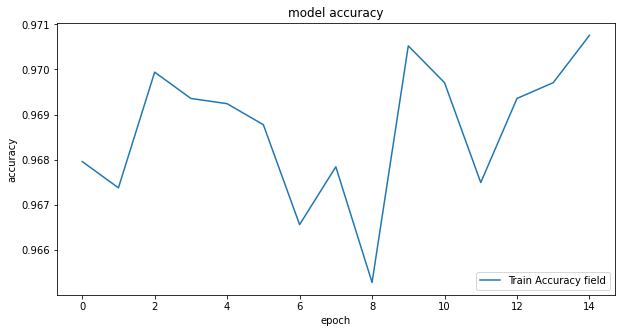

In [139]:
plt.figure(figsize=(10,5))
plt.plot(graph.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy field', 'Test Accuracy field'], loc='lower right')
plt.show()

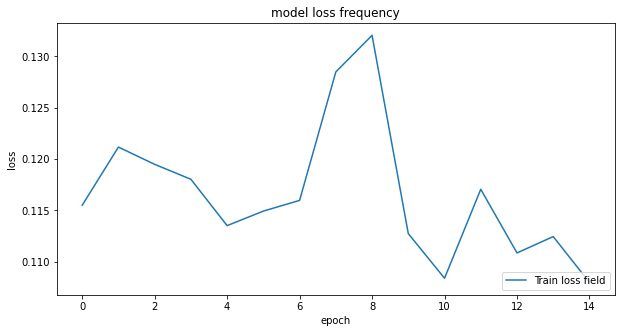

In [141]:
plt.figure(figsize=(10,5))
plt.plot(graph.history['loss'])
plt.title('model loss frequency')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss field', 'Test loss field'], loc='lower right')
plt.show()